In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from skimage import data, io, color, transform, exposure
import math as ma
import multiprocessing as mp
import itertools
# import matplotlib.cbook as cbook

# np.set_printoptions(threshold=np.inf)

In [4]:
def hough_circle(image, gradient, min_radius, max_radius):
            
    houghs = np.zeros((len(image),len(image[0]), max_radius - min_radius))
    print(len(image),len(image[0]))
    for y in range(0, len(image)):
        for x in range(0, len(image[0])):
            if image[y][x] == 255:
                 for w in range(min_radius - 1, max_radius):
                        x_weight = w * int(np.round(np.cos(gradient[y][x])))
                        y_weight = w * int(np.round(np.sin(gradient[y][x])))


                        x0 = x + x_weight
                        x1 = x - x_weight
                        y0 = y + y_weight
                        y1 = y - y_weight


                        if y0 >= 0 and x0 >= 0 and y0 < len(image) and x0 < len(image[0]):
                            houghs[y0][x0][w - min_radius] += 1

                        if y0 >= 0 and x1 >= 0 and y0 < len(image) and x1 < len(image[0]):
                            houghs[y0][x1][w - min_radius] += 1

                        if y1 >= 0 and x0 >= 0 and y1 < len(image) and x0 < len(image[0]):
                            houghs[y1][x0][w - min_radius] += 1

                        if y1 >= 0 and x1 >= 0 and y1 < len(image) and x1 < len(image[0]):
                            houghs[y1][x1][w - min_radius] += 1

                            
    return houghs


def get_threshold_circle(houghs, threshold, min_radius, jumpx, jumpy):
    over_threshold = []
    
    preXval = 0
    preYval = 0
    
    for y in range(0,len(houghs)):
        for x in range(len(houghs[0])):
            for w in range(len(houghs[0][1])):
                if houghs[y][x][w]> threshold:
                    if preXval + jumpx < x or preYval + jumpy < y:
                        over_threshold.append((x, y, w + min_radius))
                        preXval = x
                        preYval = y
                    
    return np.array(over_threshold)

def hough_line(image):    
    angles = np.deg2rad(np.arange(-90, 90))
    im_width, im_height = image.shape
    im_diag = int(np.round(np.sqrt(im_width**2 + im_height ** 2)))
    max_ps = np.linspace(-im_diag, im_diag, im_diag * 2)
        
    coses = np.cos(angles)
    sins = np.sin(angles)
    n_angles = len(angles)
    
    houghs = np.zeros((2 * im_diag, n_angles))
    
    
    for y in range(len(image)):
        for x in range(len(image[0])):
            if (image[y][x] == 255):
                for theta in range(n_angles):
                    p = int(np.round(x * coses[theta] + y * sins[theta])) + im_diag
                    houghs[p][theta] += 1
    
    return houghs, angles, max_ps
    
def get_threshold_line(houghs, threshold, jumpX, jumpY):
    
    over_threshold = []
    
    preYval = 0
    preXval = 0
    
    for y in range(len(houghs)):
        for x in range(len(houghs[0])):
            if houghs[y][x] > threshold:
                if preYval + jumpY < y or preXval + jumpX < x:
                    over_threshold.append((y, x))
                    preYval = y
                    preXval = x

    return np.array(over_threshold)

C:\Users\DavidShin\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\DavidShin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


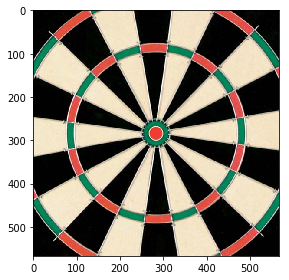

In [5]:
dart = io.imread("dart.bmp")
io.imshow(dart)

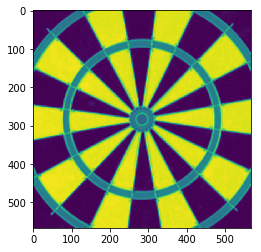

In [6]:
gray_dart = cv2.cvtColor(dart, cv2.COLOR_BGR2GRAY)
blur_dart = cv2.GaussianBlur(gray_dart, (5,5), 10)
plt.imshow(blur_dart)

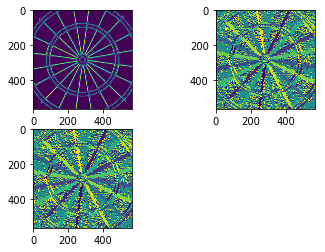

In [7]:
sobelx = cv2.Sobel(blur_dart, cv2.CV_64F, 1, 0, ksize = 5)
sobely = cv2.Sobel(blur_dart, cv2.CV_64F, 0, 1, ksize = 5)
sobel = np.sqrt(sobelx ** 2 + sobely ** 2)

gradient = np.zeros(sobel.shape)
direction = np.zeros(sobel.shape)
for y in range(len(sobely[0])):
    for x in range(len(sobely[1])):
        gradient[y][x] = ma.atan2(sobely[y][x], sobelx[y][x])
        direction[y][x] = ma.atan2(sobely[y][x], sobelx[y][x]) - np.pi/2
        
plt.figure()
plt.subplot(2,2,1)
plt.imshow(sobel)

plt.subplot(2,2,2)
plt.imshow(gradient)

plt.subplot(2,2,3)
plt.imshow(direction)

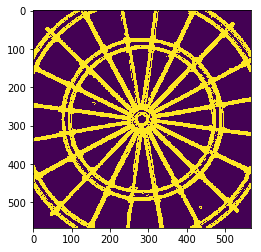

In [8]:
sobel_thresholded = np.copy(sobel)

sobel_thresholded[sobel_thresholded > 254] = 255
sobel_thresholded[sobel_thresholded <= 254] = 0

cv2.imwrite("Dart thresholded.png", sobel_thresholded)

plt.imshow(sobel_thresholded)

In [9]:
hough_dart = hough_circle(sobel_thresholded, gradient, 180, 200)

567 567


In [10]:
hough_dart_threshold = get_threshold_circle(hough_dart, 14, 180, 1, 1)

image = cv2.imread("Dart thresholded.png")

print(len(hough_dart_threshold))
for i in range(len(hough_dart_threshold)):
    cv2.circle(image, (hough_dart_threshold[i][0], hough_dart_threshold[i][1]), hough_dart_threshold[i][2], (0,0,255), 1)
    
cv2.imwrite('Dart result.png', image)

7


True

In [11]:
hough_dart_line, angles, max_dis = hough_line(sobel_thresholded)

In [12]:
# maximum = np.argmax(hough_dart_line)
# distance = max_dis[int(np.round(maximum / hough_dart_line.shape[1]))]
# angle = angles[maximum % hough_dart_line.shape[1]]

hough_dart_line_threshold = get_threshold_line(hough_dart_line, 500, 20, 20)

print(len(hough_dart_line_threshold))

image2 = cv2.imread("Dart thresholded.png")

for y in range(len(hough_dart_line_threshold)):
    distance = max_dis[hough_dart_line_threshold[y][0]]
    angle = angles[hough_dart_line_threshold[y][1]]
    
#     print(angles)
    
#     print(angle)
    
    
    if angle != 0:
        m = -np.cos(angle) / np.sin(angle)
        b = distance / np.sin(angle)
    else:
        m = -np.cos(angle)
        b = distance
    
            
    x0 = 0
    x1 = 0
    for x in range(len(sobel_thresholded[0])):
        y0 = int(np.round(m * x + b))
        
        if y0 >= 0 and y0 < len(sobel_thresholded):
            
            if sobel_thresholded[y0][x] == 255:
                x0 = x
                break
            
    for x in range(len(sobel_thresholded[0]) - 1,-1, -1):
        y0 = int(np.round(m * x + b))
        
        if y0 >= 0 and y0 < len(sobel_thresholded):
            if sobel_thresholded[y0][x] == 255:
                x1 = x
                break
#     for x in range(len(sobel_thresholded[0])):
#         if sobel_threshold[y_intersect][x] == 255:
#             if first_x = False:
#                 x0 = x
#         if sobel_threshold[y_intersect]
#             break
    y0 = int(np.round(m * x0 + b))
    y1 = int(np.round(m * x1 + b))
    
    cv2.line(image2, (x0,y0), (x1, y1), (0,0,255), 3)
    
cv2.imwrite('Line result.png', image2)
# for i in range(len(hough_dart_line)):
    
# m = -np.cos(angle) / np.sin(angle)
# b = distance / np.sin(angle)

# y0 = int(np.round(m * 0 + b))
# y1 = int(np.round(m * len(sobel_thresholded) + b))

# image2 = cv2.imread("Dart thresholded.png")
# cv2.line(image2, (0, y0), (len(sobel_thresholded),y1), (0,0,255), 10)

# plt.imshow(image2)

11


True

C:\Users\DavidShin\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\DavidShin\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


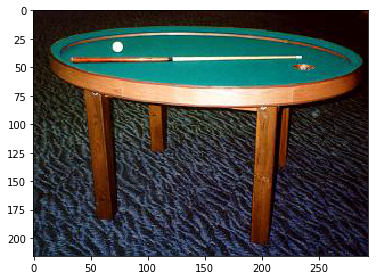

In [14]:
ellipse = io.imread("ellipse_images/ellipse0.jpg")
io.imshow(ellipse)